In [1]:
# Import Libs
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('float_format', '{:.2f}'.format)
import warnings
import re
import glob
warnings.filterwarnings('ignore')
import string
from wordcloud import WordCloud, STOPWORDS


In [2]:
# Read CSV
# trend_videos = pd.read_csv('archive/US_youtube_trending_data.csv')

path = r'..\..\dataset\archive'
all_files = glob.glob(path+ "/*.csv")

li =[]

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

trend_videos = pd.concat(li, axis=0, ignore_index=True)

In [3]:
# List coumn names
trend_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499874 entries, 0 to 499873
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           499874 non-null  object
 1   title              499874 non-null  object
 2   publishedAt        499874 non-null  object
 3   channelId          499874 non-null  object
 4   channelTitle       499873 non-null  object
 5   categoryId         499874 non-null  int64 
 6   trending_date      499874 non-null  object
 7   tags               499874 non-null  object
 8   view_count         499874 non-null  int64 
 9   likes              499874 non-null  int64 
 10  dislikes           499874 non-null  int64 
 11  comment_count      499874 non-null  int64 
 12  thumbnail_link     499874 non-null  object
 13  comments_disabled  499874 non-null  bool  
 14  ratings_disabled   499874 non-null  bool  
 15  description        493768 non-null  object
dtypes: bool(2), int64(5)

In [4]:
# List first few videos for easy observation
trend_videos.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,s9FH4rDMvds,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11T22:21:49Z,UCGfBwrCoi9ZJjKiUK8MmJNw,Pietro Guedes,22,2020-08-12T00:00:00Z,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,487,4500,https://i.ytimg.com/vi/s9FH4rDMvds/default.jpg,False,False,"Salve rapaziada, neste vídeo me declarei pra e..."
1,jbGRowa5tIk,ITZY “Not Shy” M/V TEASER,2020-08-11T15:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|ITZY|있지|ITZY Video|ITZY ...,6000070,714310,15176,31040,https://i.ytimg.com/vi/jbGRowa5tIk/default.jpg,False,False,ITZY Not Shy M/V[ITZY Official] https://www.yo...
2,3EfkCrXKZNs,Oh Juliana PARÓDIA - MC Niack,2020-08-10T14:59:00Z,UCoXZmVma073v5G1cW82UKkA,As Irmãs Mota,22,2020-08-12T00:00:00Z,OH JULIANA PARÓDIA|MC Niack PARÓDIA|PARÓDIAS|A...,2296748,39761,5484,0,https://i.ytimg.com/vi/3EfkCrXKZNs/default.jpg,True,False,Se inscrevam meus amores! 📬 Quer nos mandar al...
3,gBjox7vn3-g,Contos de Runeterra: Targon | A Estrada Tortuosa,2020-08-11T15:00:09Z,UC6Xqz2pm50gDCORYztqhDpg,League of Legends BR,20,2020-08-12T00:00:00Z,Riot|Riot Games|League of Legends|lol|trailer|...,300510,46222,242,2748,https://i.ytimg.com/vi/gBjox7vn3-g/default.jpg,False,False,Você se unirá aos Lunari e aos Solari em Targo...
4,npoUGx7UW7o,Entrevista com Thammy Miranda | The Noite (10/...,2020-08-11T20:04:02Z,UCEWOoncsrmirqnFqxer9lmA,The Noite com Danilo Gentili,23,2020-08-12T00:00:00Z,The Noite|The Noite com Danilo Gentili|Danilo ...,327235,22059,3972,2751,https://i.ytimg.com/vi/npoUGx7UW7o/default.jpg,False,False,Danilo Gentili recebe Thammy Miranda. Após pas...


In [5]:
# If video has no description add a generic one
trend_videos["description"] = trend_videos["description"].fillna(value="Video has no description")

In [6]:
# Select the tags and total video view count for the dataframe
cols = ['tags', 'view_count']
vids = trend_videos[cols]

In [7]:
# Create a list containing tuples with the tags for each video and the total video views
tags_with_viewcount_list = list(vids.itertuples(index=False, name=None))

In [8]:
# create a giant dictionary with the tag name for a 
# key and a value that is a list of video views for each time the tag appeared
tag_data = {}


# build list of tags
def buildTagsArray(tagDict):
    tags = []
    for x in tagDict:
        tags.append(x)
    return tags

# find the mean video views for videos that use the tag
def findMean(tagDict):
    averages = []
    for x in tagDict:
        averages.append(sum(tagDict[x])//len(tagDict[x]))
    return averages

# find the median video views for videos that use the tag
def findMedian(tagDict):
    medians = []
    for x in tagDict:
        tagDict[x].sort()
        mid = len(tagDict[x]) // 2
        res = (tagDict[x][mid] + tagDict[x][~mid]) // 2
        medians.append(res)
    return medians

# find the total video views for all videos that use the tag combined
def findTotals(tagDict):
    totals = []
    for x in tagDict:
        totals.append(sum(tagDict[x]))
    return totals

# find the frequency of how often the tags appear in videos
def frequency_used(tagDict):
    count = []
    for x in tagDict:
        count.append(len(tagDict[x]))
    return count

# build the giant dictionary storing tag data
for tags in tags_with_viewcount_list:
    for tag in tags[0].split('|'):

        if tag not in tag_data:
            tag_data[tag] = [tags[1]]
        else:
            tag_data[tag].append(tags[1])


data = {'tag': buildTagsArray(tag_data),
        'frequency_used': frequency_used(tag_data),
        'total_view_count': findTotals(tag_data),
        'mean_view_count': findMean(tag_data),
        'median_view_count': findMedian(tag_data)
        }

# Create a new dataframe that stores the above compiled data
new_df = pd.DataFrame(data, columns =['tag', 'frequency_used', 'total_view_count', 'mean_view_count', 'median_view_count'])

[Text(0.5, 1.0, 'Total View Count By Tag')]

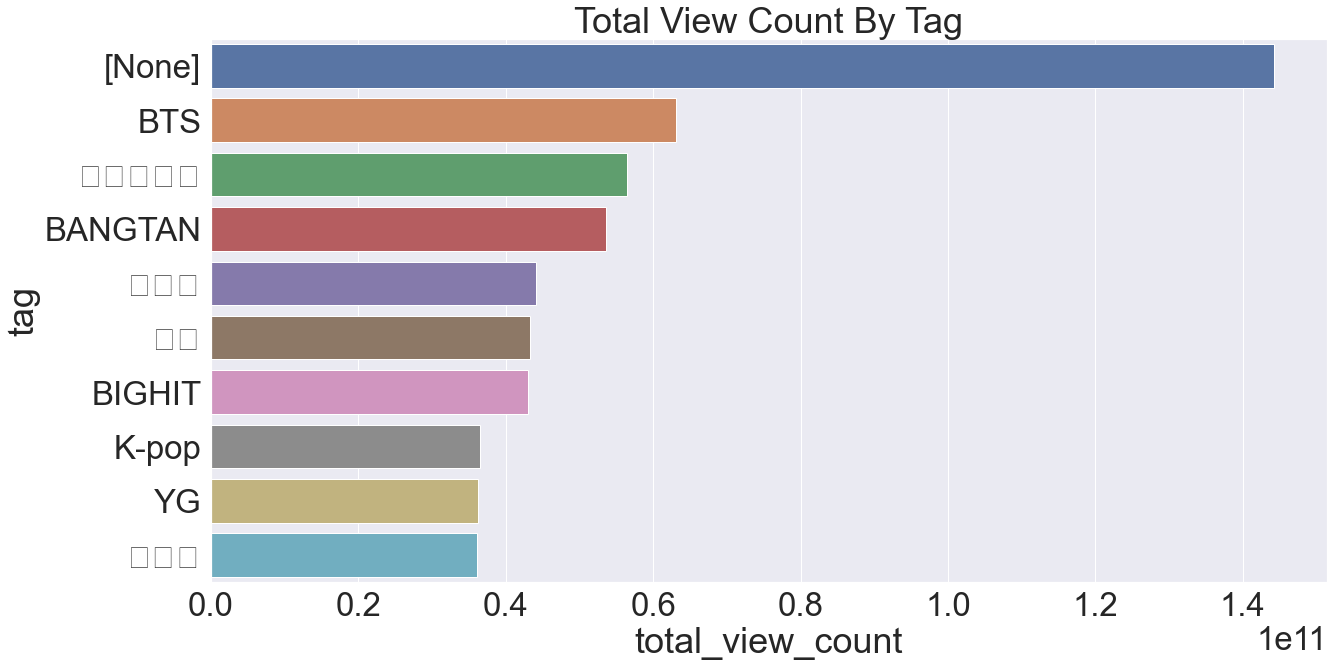

In [9]:
# build a barplot graph that displays the total view count for the tags with the highest total view count
select_cols = ['tag', 'total_view_count']
x = new_df[select_cols].sort_values(by=['total_view_count'], ascending=False).head(10)
sns.set(font_scale=3)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='total_view_count', y='tag').set(title='Total View Count By Tag')

[Text(0.5, 1.0, 'Frequency of Tag Use')]

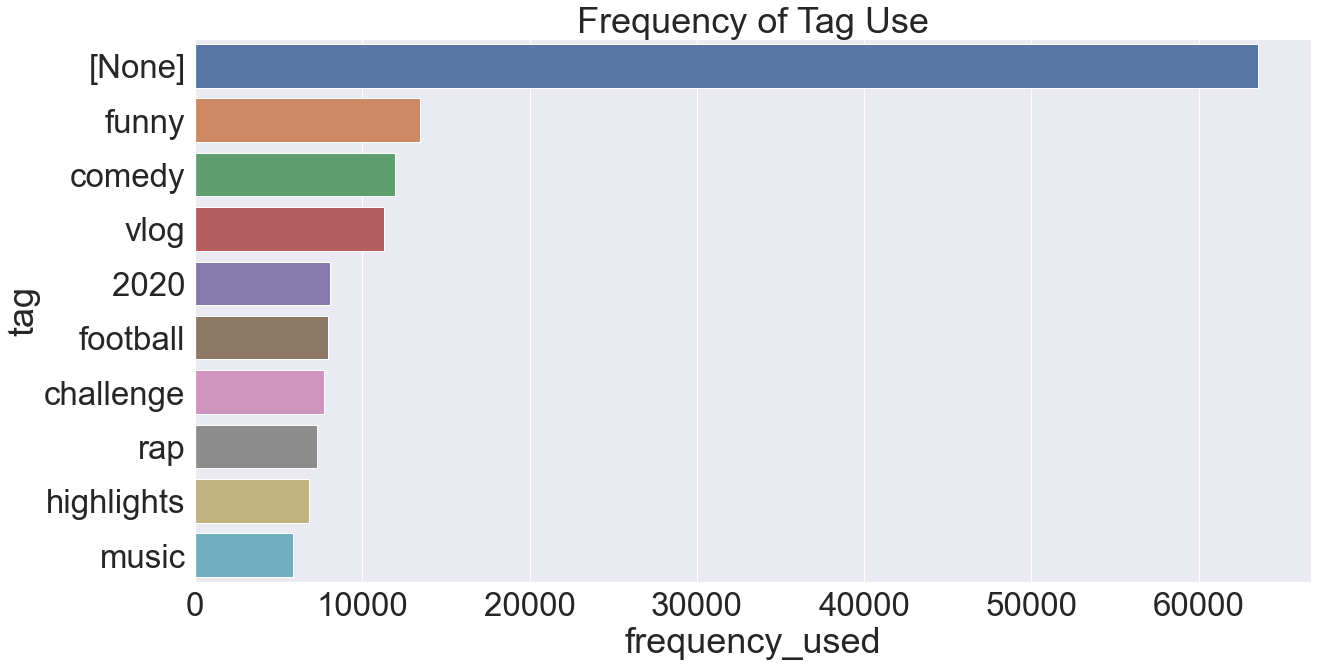

In [10]:
# build a barplot graph that displays the frequency of tag use for the tags that are used the most frequently
select_cols = ['tag', 'frequency_used']
x = new_df[select_cols].sort_values(by=['frequency_used'], ascending=False).head(10)
sns.set(font_scale=3)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='frequency_used', y='tag').set(title='Frequency of Tag Use')

[Text(0.5, 1.0, 'Mean View Count By Tag')]

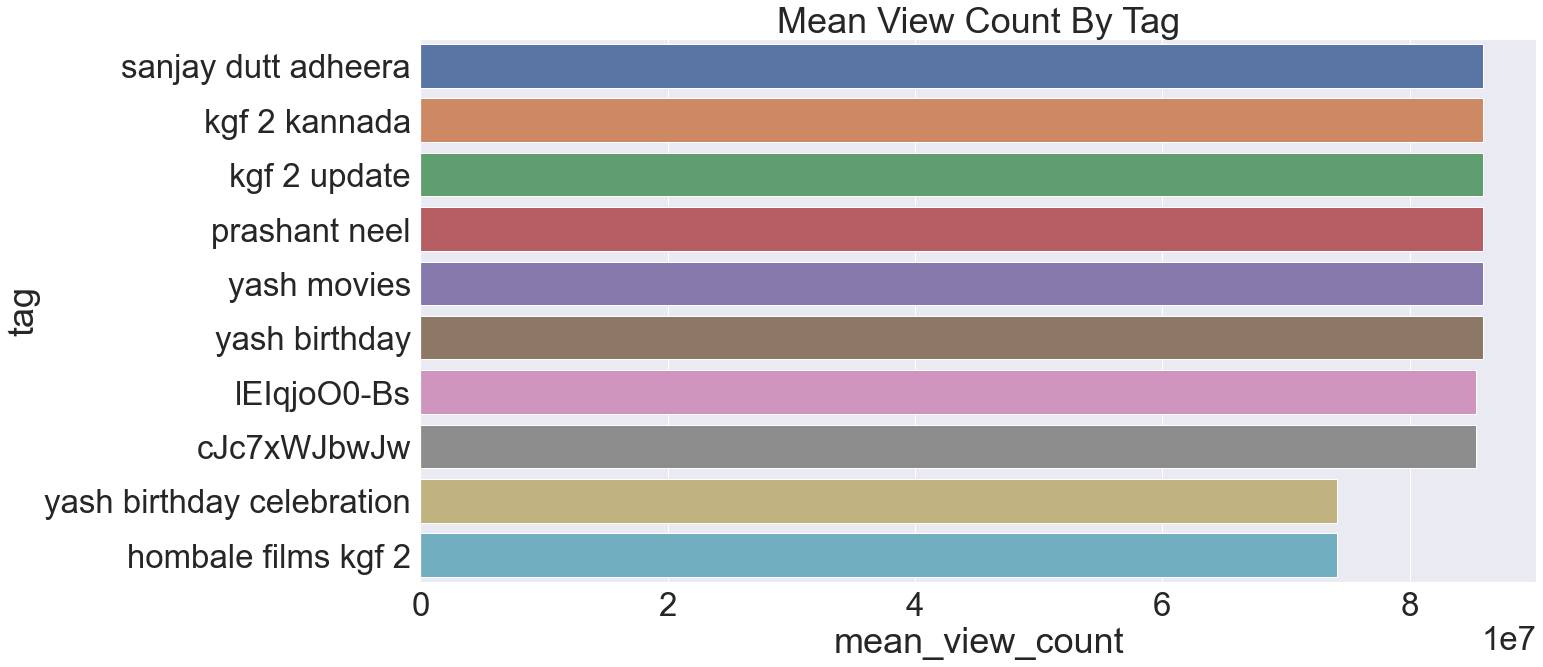

In [11]:
# build a barplot graph that displays the mean view count by tag for the tags with the highest mean view count
select_cols = ['tag', 'mean_view_count']
x = new_df[select_cols].sort_values(by=['mean_view_count'], ascending=False).head(10)
sns.set(font_scale=3)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='mean_view_count', y='tag').set(title='Mean View Count By Tag')

[Text(0.5, 1.0, 'Medain View Count By Tag')]

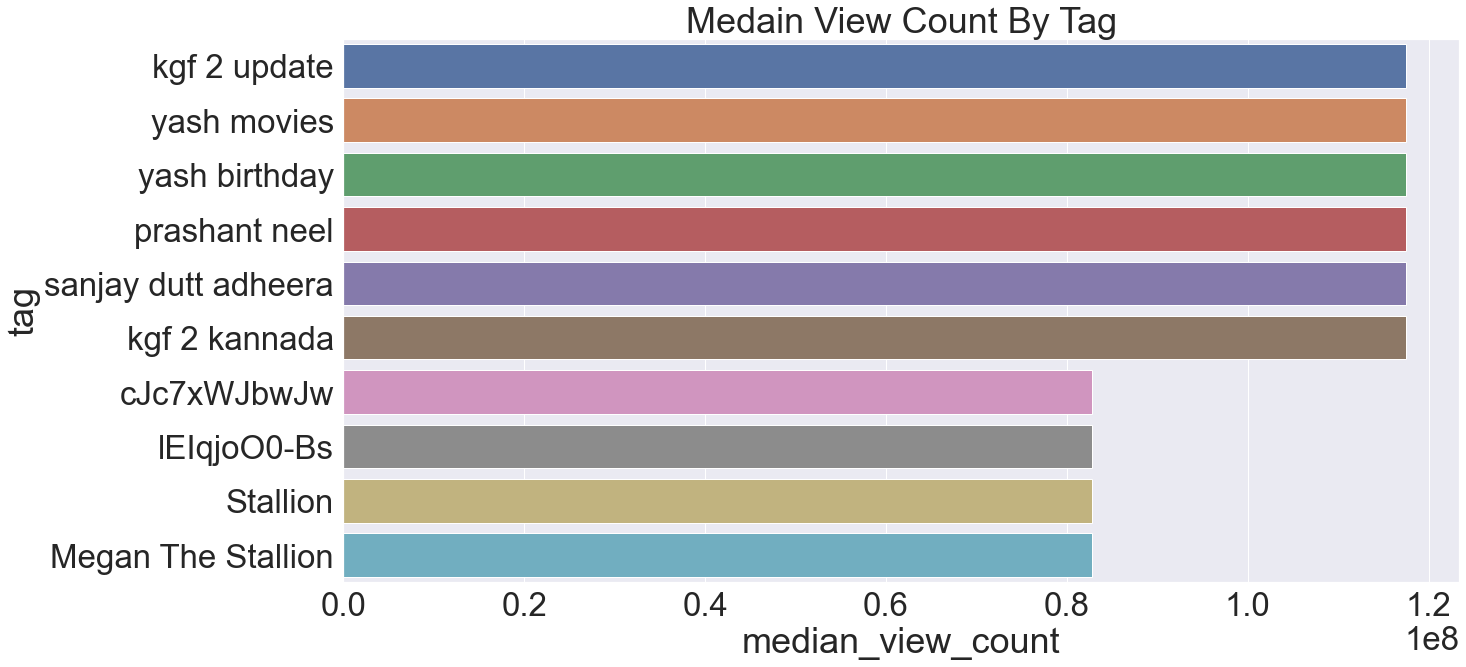

In [12]:
# build a barplot graph that displays the median view count by tag for the tags with the highest median view count
select_cols = ['tag', 'median_view_count']
x = new_df[select_cols].sort_values(by=['median_view_count'], ascending=False).head(10)
sns.set(font_scale=3)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='median_view_count', y='tag').set(title='Medain View Count By Tag')

(-0.5, 1999.5, 999.5, -0.5)

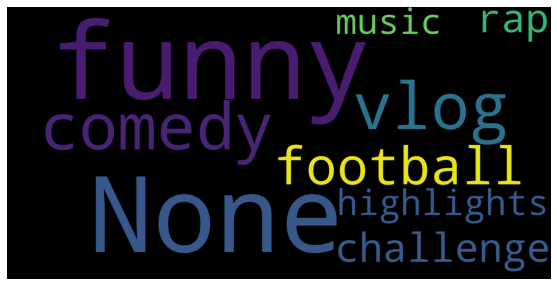

In [13]:
# build a wordcloud that displays the names of the most frequently used tags
select_cols = ['tag', 'frequency_used']

tagData = new_df[select_cols].sort_values(by=['frequency_used'], ascending=False).head(10)

tags_and_frequency = list(tagData.itertuples(index=False, name=None))

tags_only = []

for t in tags_and_frequency:
    tags_only.append(re.sub('[^a-zA-Z]', ' ', t[0]))
 
wordcld = WordCloud(width= 2000, height= 1000, stopwords= set(STOPWORDS)).generate(' '.join(tags_only))
plt.figure(figsize=(15,5))
plt.imshow(wordcld)
plt.axis('off')
